<a href="https://colab.research.google.com/github/hashini-fernando/Machine_Learning_Projects/blob/main/Big_Mart_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BIG MART SALES PREDICTION

Importing the Dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV  # Import GridSearchCV
from xgboost import XGBRegressor
from sklearn import metrics
from scipy import stats
from sklearn.model_selection import  GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

Data Collection and Processing

In [ ]:
# loading the data from csv file to Pandas DataFrame
big_mart_data = pd.read_csv('Train.csv')

In [ ]:
# first 5 rows of the dataframe
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
# number of data points & number of features
big_mart_data.shape

(8523, 12)

In [ ]:
# getting some information about thye dataset
big_mart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Categorical Features:

- Item_Identifier
- Item_Fat_Content
- Item_Type
- Outlet_Identifier
- Outlet_Size
- Outlet_Location_Type
- Outlet_Type


Numerical Features:

- Item_Weight
- Item_Visibility
- Item_MRP
- Outlet_Establishment_Year
- Item_Outlet_Sales



In [ ]:
# checking for missing values
big_mart_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Handaling Missing Values

Mean --> average

Mode --> more repeated value

In [ ]:
# mean value of "Item_Weight" column
big_mart_data['Item_Weight'].mean()

12.857645184135976

In [ ]:
# filling the missing values in "Item_weight column" with "Mean" value
big_mart_data['Item_Weight'].fillna(big_mart_data['Item_Weight'].mean(), inplace=True)

In [ ]:
# mode of "Outlet_Size" column
mode_of_Outlet_size = big_mart_data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))

In [ ]:
# filling the missing values in "Outlet_Size" column with Mode
miss_values = big_mart_data['Outlet_Size'].isnull()
big_mart_data.loc[miss_values, 'Outlet_Size'] = big_mart_data.loc[miss_values, 'Outlet_Type'].apply(lambda x: mode_of_Outlet_size[x])

In [ ]:
print(mode_of_Outlet_size)

Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


In [ ]:
# checking for missing values
big_mart_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [ ]:
print(mode_of_Outlet_size)

Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


Data Analysis

In [ ]:
big_mart_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


Numerical Features

In [ ]:
sns.set()

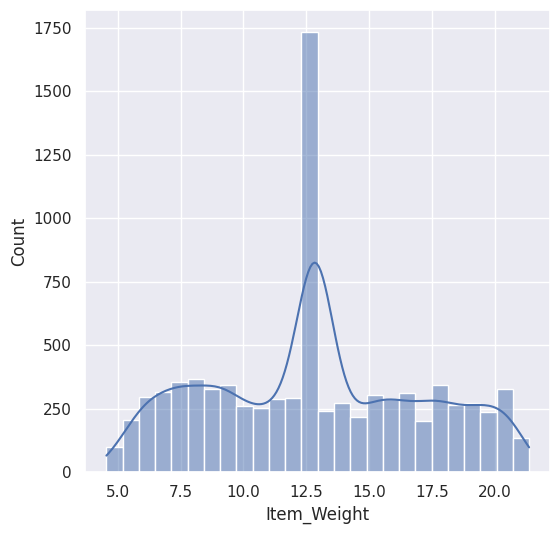

In [ ]:
# Item_Weight distribution
plt.figure(figsize=(6,6))
sns.histplot(big_mart_data['Item_Weight'], kde=True)
plt.show()

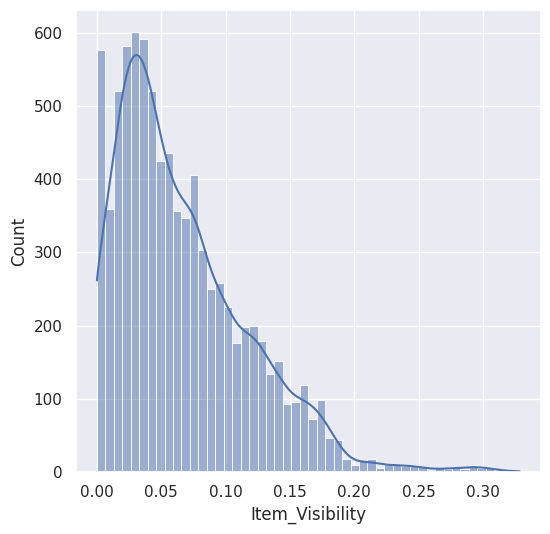

In [ ]:
# Item Visibility distribution
plt.figure(figsize=(6,6))
sns.histplot(big_mart_data['Item_Visibility'], kde=True)
plt.show()

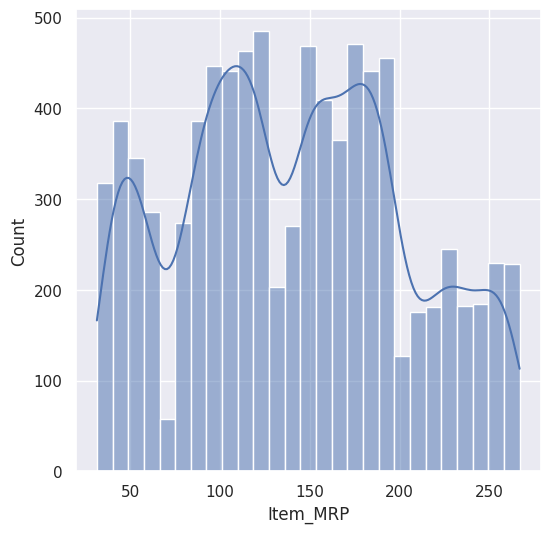

In [ ]:
# Item MRP distribution
plt.figure(figsize=(6,6))
sns.histplot(big_mart_data['Item_MRP'], kde=True)
plt.show()

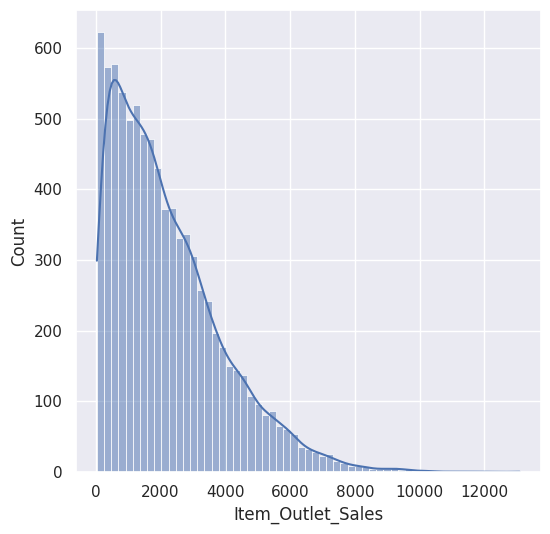

In [ ]:
# Item_Outlet_Sales distribution
plt.figure(figsize=(6,6))
sns.histplot(big_mart_data['Item_Outlet_Sales'], kde=True)
plt.show()

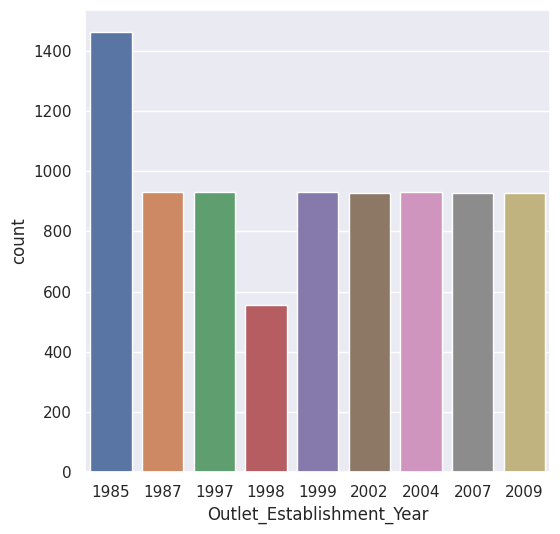

In [ ]:
# Outlet_Establishment_Year column
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Establishment_Year', data=big_mart_data)
plt.show()

Categorical Features

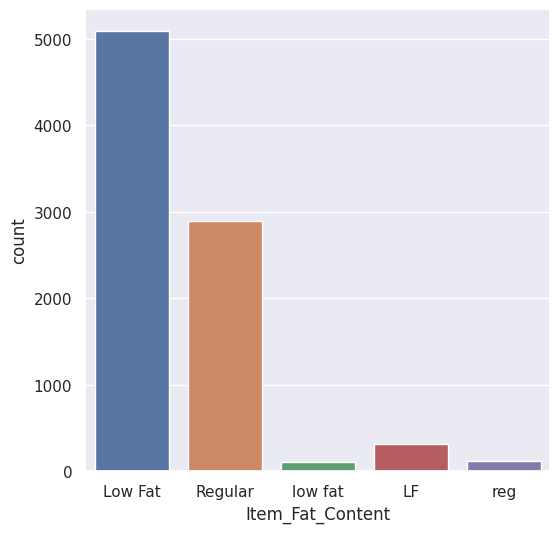

In [ ]:
# Item_Fat_Content column
plt.figure(figsize=(6,6))
sns.countplot(x='Item_Fat_Content', data=big_mart_data)
plt.show()

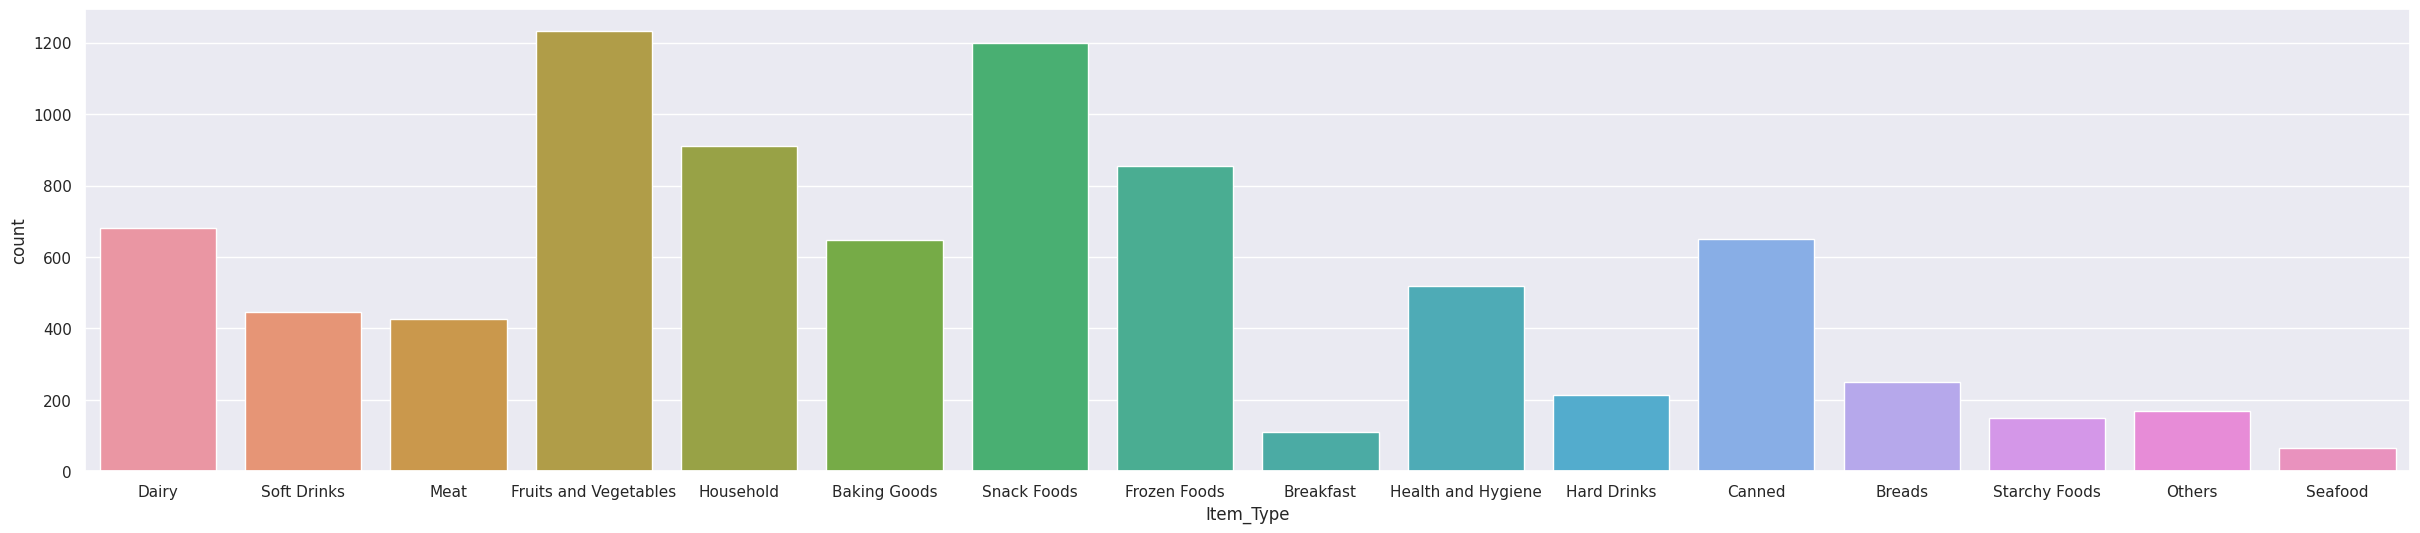

In [ ]:
# Item_Type column
plt.figure(figsize=(30,6))
sns.countplot(x='Item_Type', data=big_mart_data)
plt.show()

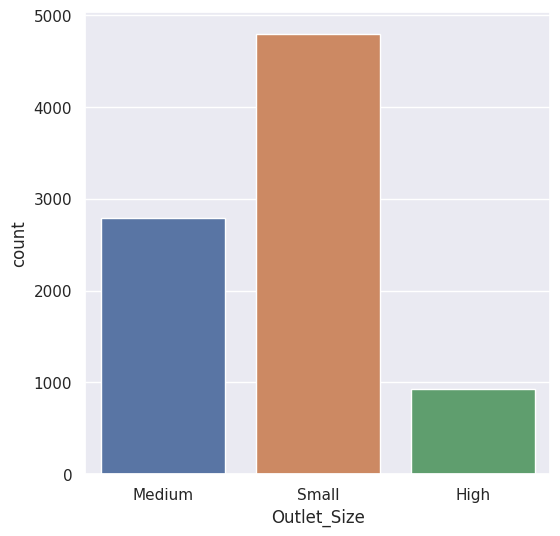

In [ ]:
# Outlet_Size column
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Size', data=big_mart_data)
plt.show()

Data Pre-Processing

In [ ]:
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
big_mart_data['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [ ]:
big_mart_data.replace({'Item_Fat_Content': {'low fat':'Low Fat','LF':'Low Fat', 'reg':'Regular'}}, inplace=True)

In [ ]:
big_mart_data['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

Label Encoding

In [ ]:
encoder = LabelEncoder()

In [ ]:
big_mart_data['Item_Identifier'] = encoder.fit_transform(big_mart_data['Item_Identifier'])

big_mart_data['Item_Fat_Content'] = encoder.fit_transform(big_mart_data['Item_Fat_Content'])

big_mart_data['Item_Type'] = encoder.fit_transform(big_mart_data['Item_Type'])

big_mart_data['Outlet_Identifier'] = encoder.fit_transform(big_mart_data['Outlet_Identifier'])

big_mart_data['Outlet_Size'] = encoder.fit_transform(big_mart_data['Outlet_Size'])

big_mart_data['Outlet_Location_Type'] = encoder.fit_transform(big_mart_data['Outlet_Location_Type'])

big_mart_data['Outlet_Type'] = encoder.fit_transform(big_mart_data['Outlet_Type'])

In [ ]:
# Feature Engineering
current_year = 2024
big_mart_data['Outlet_Years'] = current_year - big_mart_data['Outlet_Establishment_Year']


In [ ]:
# Feature Scaling
scaler = StandardScaler()
big_mart_data[['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Years']] = scaler.fit_transform(
    big_mart_data[['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Years']])

In [ ]:
# Dealing with Skewed Features
big_mart_data['Item_Outlet_Sales'] = np.log1p(big_mart_data['Item_Outlet_Sales'])

In [ ]:
# Remove Unnecessary Columns
big_mart_data.drop(columns=['Item_Identifier', 'Outlet_Establishment_Year'], inplace=True)


In [ ]:
big_mart_data.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Years
0,-0.841872,0,-0.970732,4,1.747454,9,1,0,1,2.222005,-0.139541
1,-1.641706,1,-0.908111,14,-1.489023,3,1,2,2,1.959641,-1.334103
2,1.098554,0,-0.956917,10,0.010040,9,1,0,1,2.157429,-0.139541
3,1.500838,1,-1.281758,6,0.660050,0,2,2,0,2.027841,-0.020085
4,-0.929428,0,-1.281758,9,-1.399220,1,0,2,1,2.067300,1.293934


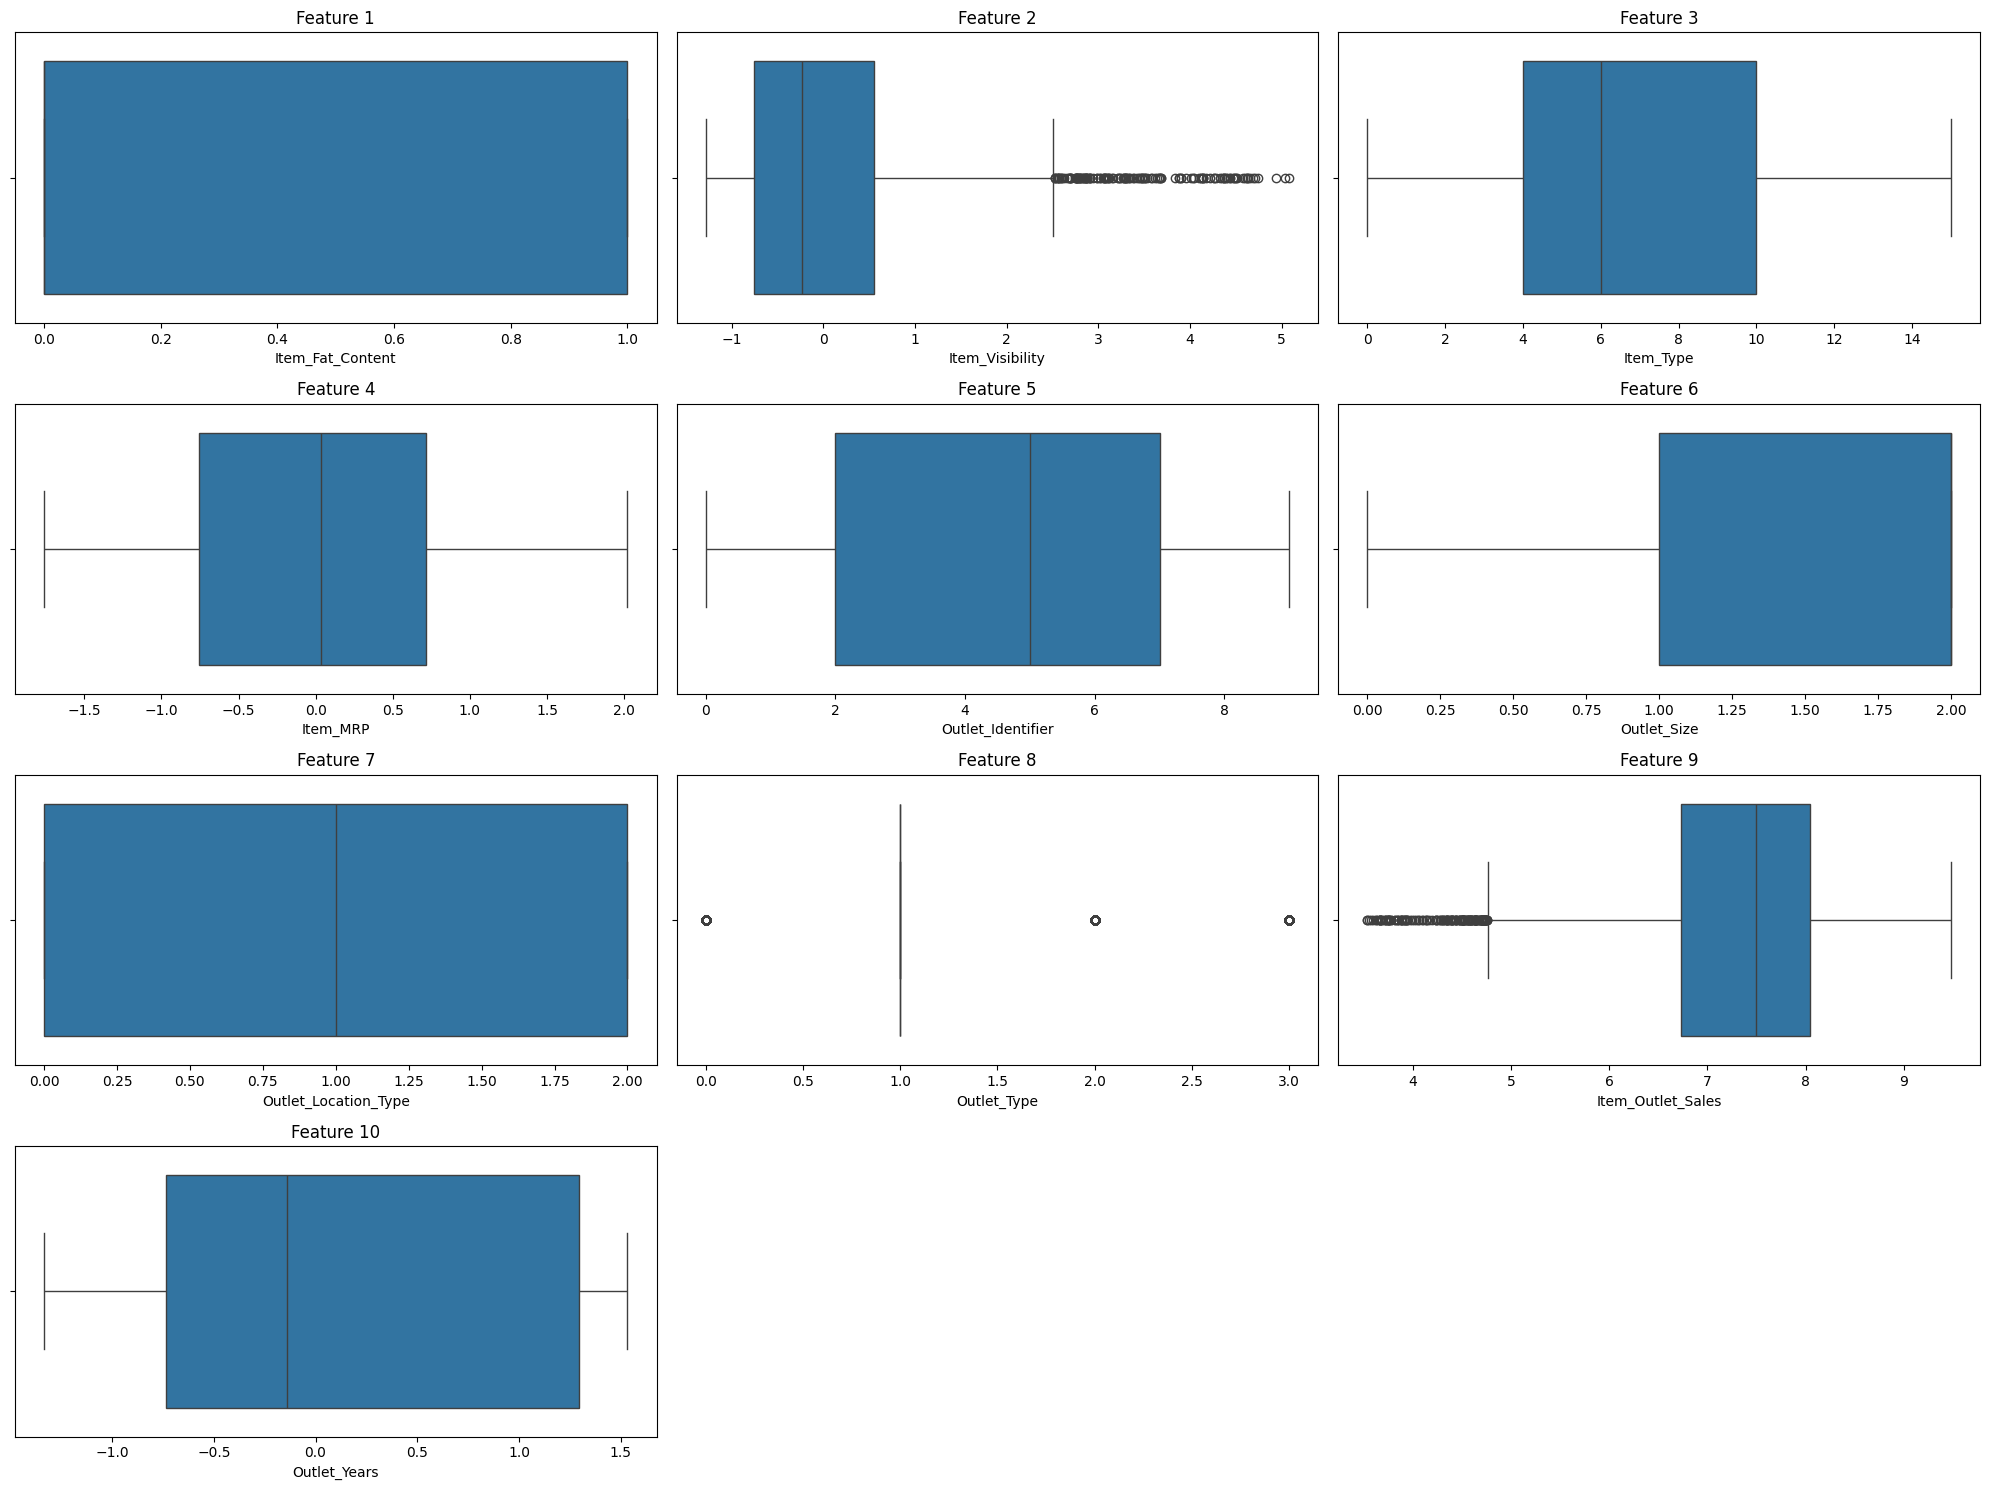

In [ ]:
# Checking for outliers using boxplots for the first 10 features
plt.figure(figsize=(20, 15))
for i, column in enumerate(big_mart_data.columns[1:11], start=1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=big_mart_data[column])
    plt.title('Feature ' + str(i))
plt.tight_layout()
plt.show()

In [ ]:
# Remove outliers using Z-score (threshold: 3)
z_scores = np.abs(stats.zscore(big_mart_data.iloc[:, :-1]))
filtered_entries = (z_scores < 3).all(axis=1)
big_mart_data = big_mart_data[filtered_entries]

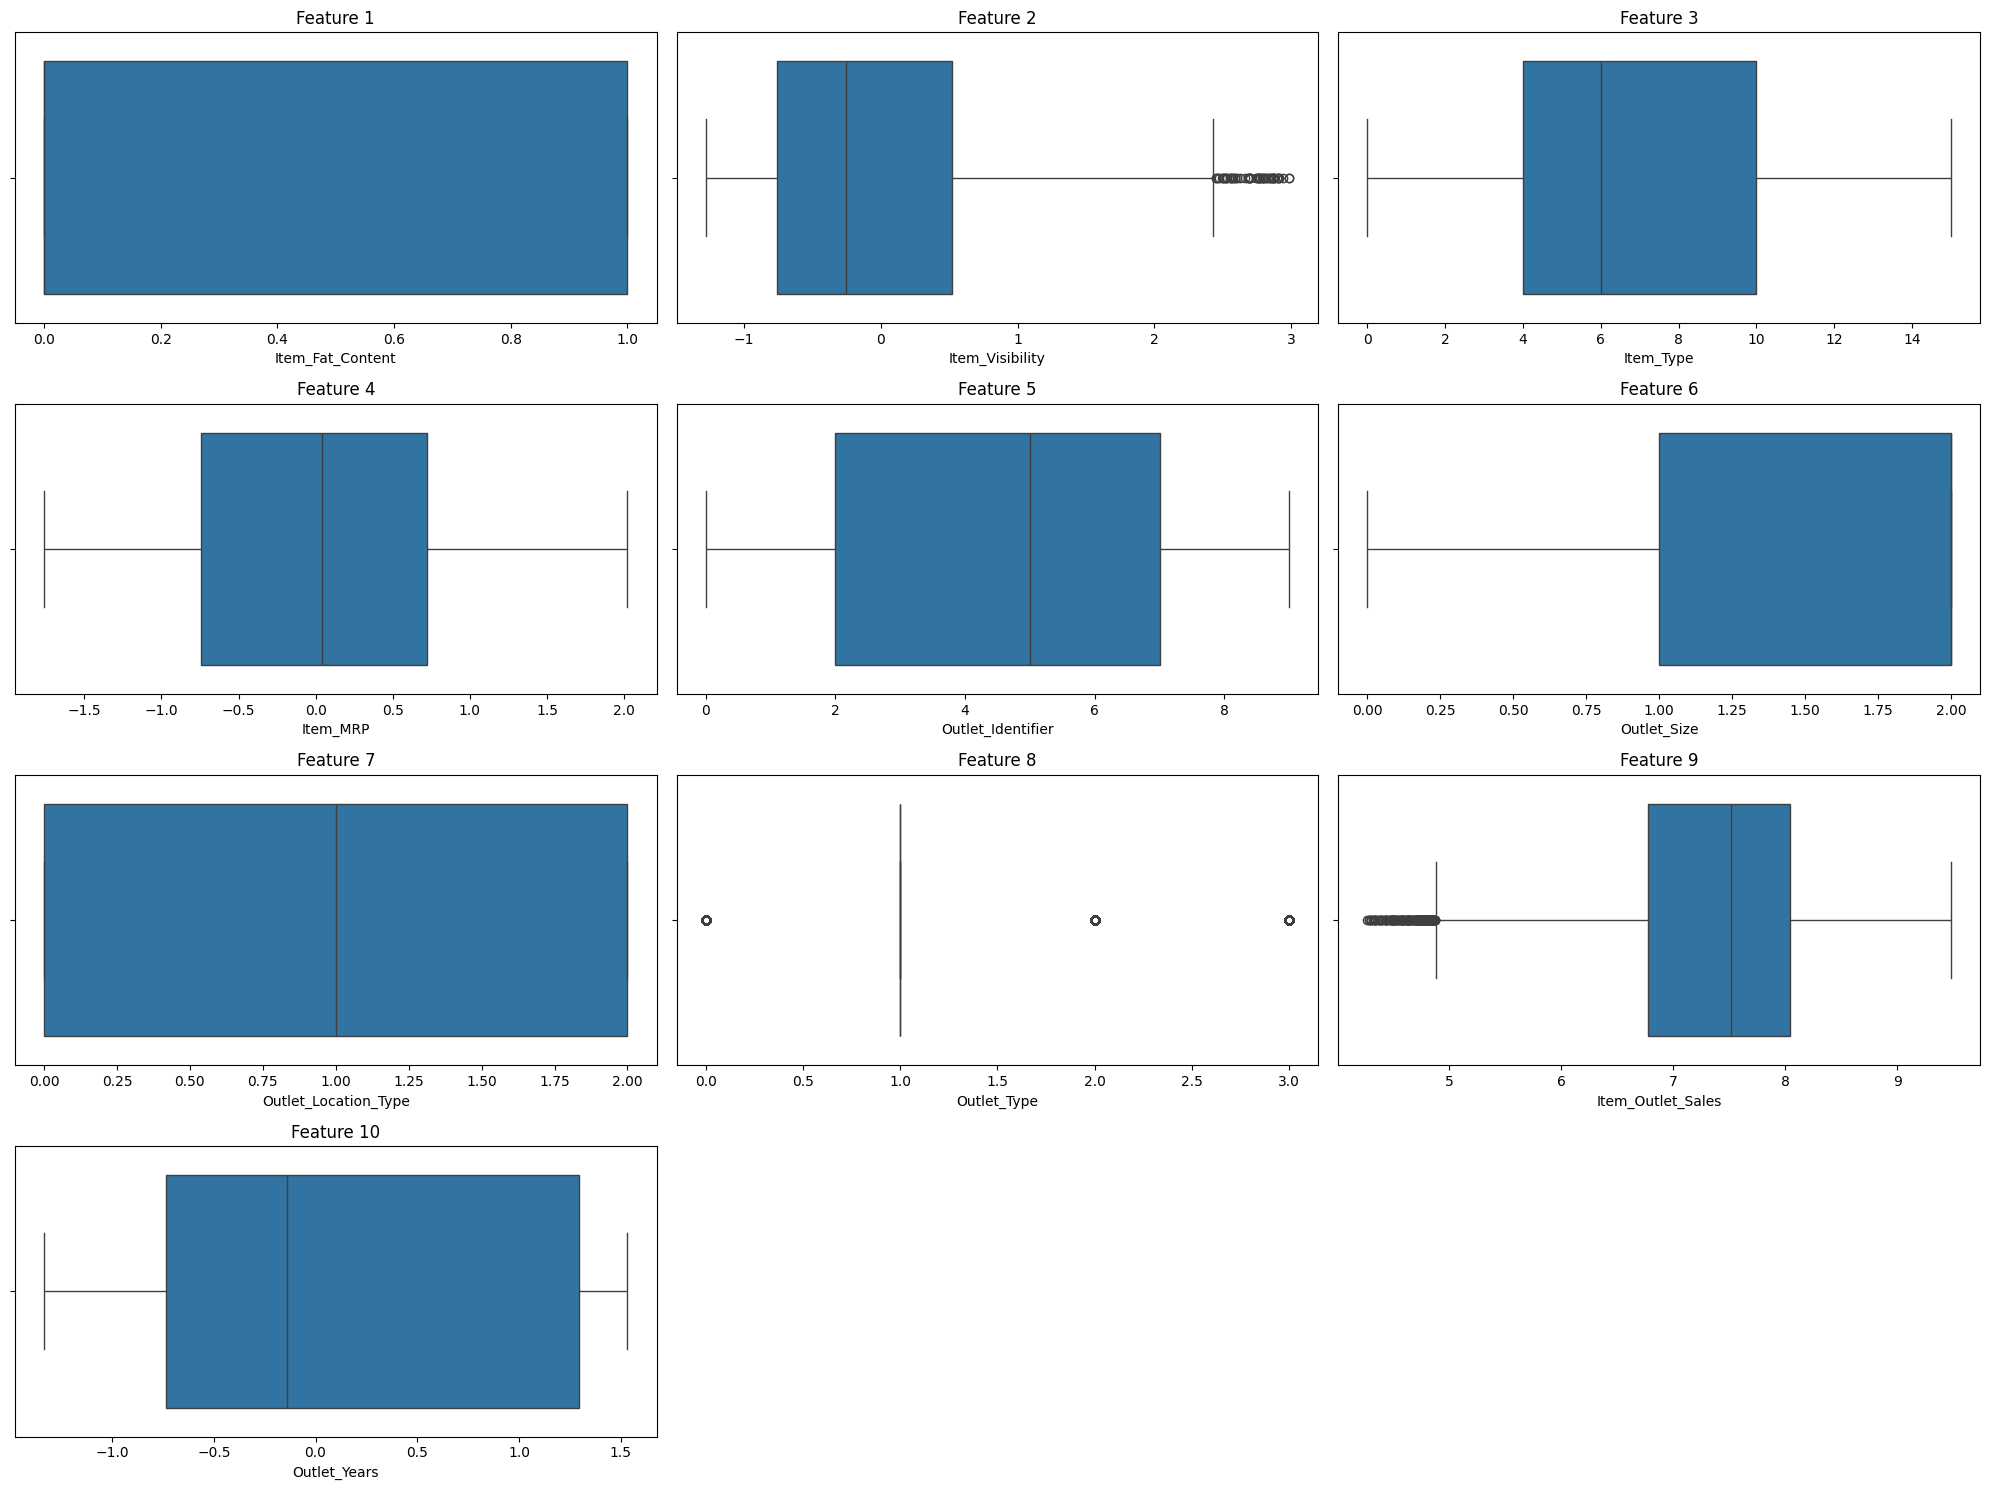

In [ ]:
# Checking for outliers using boxplots for the first 10 features
plt.figure(figsize=(20, 15))
for i, column in enumerate(big_mart_data.columns[1:11], start=1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=big_mart_data[column])
    plt.title('Feature ' + str(i))
plt.tight_layout()
plt.show()


Splitting features and Target

In [ ]:
X = big_mart_data.drop(columns='Item_Outlet_Sales', axis=1)
Y = big_mart_data['Item_Outlet_Sales']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [ ]:
print(X)

      Item_Weight  Item_Fat_Content  Item_Visibility  Item_Type  Item_MRP  \
0       -0.841872                 0        -0.970732          4  1.747454   
1       -1.641706                 1        -0.908111         14 -1.489023   
2        1.098554                 0        -0.956917         10  0.010040   
3        1.500838                 1        -1.281758          6  0.660050   
4       -0.929428                 0        -1.281758          9 -1.399220   
...           ...               ...              ...        ...       ...   
8518    -1.418084                 0        -0.181193         13  1.180783   
8519    -1.059578                 1        -0.371154          0 -0.527301   
8520    -0.534243                 0        -0.599784          8 -0.897208   
8521    -1.336444                 1         1.532880         13 -0.607977   
8522     0.459634                 0        -0.411936         14 -1.052261   

      Outlet_Identifier  Outlet_Size  Outlet_Location_Type  Outlet_Type  \


In [ ]:
print(Y)

0       8.225808
1       6.096776
2       7.648868
3       6.597664
4       6.903451
          ...   
8518    7.929984
8519    6.310436
8520    7.085159
8521    7.521100
8522    6.642056
Name: Item_Outlet_Sales, Length: 8372, dtype: float64


In [ ]:
print(X.shape, X_train.shape, X_test.shape)

(8372, 10) (6697, 10) (1675, 10)


Machine Learning Model Training

XGBoost Regressor

In [ ]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

In [ ]:
#Hyperparameter tuning using GridSearchCV for XGBRegressor
grid_search = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, Y_train)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='r2')

In [ ]:
# Get the best parameters from the grid search
best_params = grid_search.best_params_
print('Best Parameters:', best_params)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [ ]:
# Use the best parameters to train the model
regressor = XGBRegressor(**best_params)
regressor.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Evaluation

In [ ]:
# prediction on training data
train_predictions_XG = regressor.predict(X_train)

In [ ]:
# prediction on test data
test_predictions_XG = regressor.predict(X_test)


In [ ]:
# EMean Absolute Error
mae_train_XG = mean_absolute_error(Y_train, train_predictions_XG)
mae_test_XG = mean_absolute_error(Y_test, test_predictions_XG)
print(f"Mean Absolute Error_XG (Train): {mae_train_XG}")
print(f"Mean Absolute Error_XG (Test): {mae_test_XG}")

Mean Absolute Error_XG (Train): 0.04819619715331076
Mean Absolute Error_XG (Test): 0.04857945286880362


In [ ]:
# Mean Squared Error

mse_train_XG = mean_squared_error(Y_train, train_predictions_XG)
mse_test_XG = mean_squared_error(Y_test, test_predictions_XG)

print(f"Mean Squared Error_XG (Train): {mse_train_XG}")
print(f"Mean Squared Error_XG (Test): {mse_test_XG}")

Mean Squared Error_XG (Train): 0.00404328501423143
Mean Squared Error_XG (Test): 0.004037094845395079


In [ ]:
# Root Mean Squared Error
rmse_train_XG = np.sqrt(mse_train_XG)
rmse_test_XG = np.sqrt(mse_test_XG)

print(f"Root Mean Squared Error_XG (Train): {rmse_train_XG}")
print(f"Root Mean Squared Error_XG (Test): {rmse_test_XG}")

Root Mean Squared Error_XG (Train): 0.0635868305094021
Root Mean Squared Error_XG (Test): 0.06353813693676483


In [ ]:
# R-squared
r2_train_XG = r2_score(Y_train, train_predictions_XG)
r2_test_XG = r2_score(Y_test, test_predictions_XG)

print(f"R-squared_XG (Train): {r2_train_XG}")
print(f"R-squared_XG (Test): {r2_test_XG}")


R-squared_XG (Train): 0.7129188534061816
R-squared_XG (Test): 0.7309293572170663


In [ ]:
# Create a DataFrame to compare actual and predicted results
comparison_df = pd.DataFrame({
    'Actual_Sales': Y_test,
    'Predicted_Sales': test_predictions_XG
})

print (comparison_df)

      Actual_Sales  Predicted_Sales
8469      1.932897         1.959879
2674      2.212585         2.167469
6054      1.996529         2.128867
1563      2.145877         2.047705
852       2.185866         2.202302
...            ...              ...
7058      2.201029         2.198638
5431      2.194591         2.164324
359       2.186060         2.165004
5562      2.129834         2.095601
2816      2.248142         2.171121

[1666 rows x 2 columns]


Visualization and Results

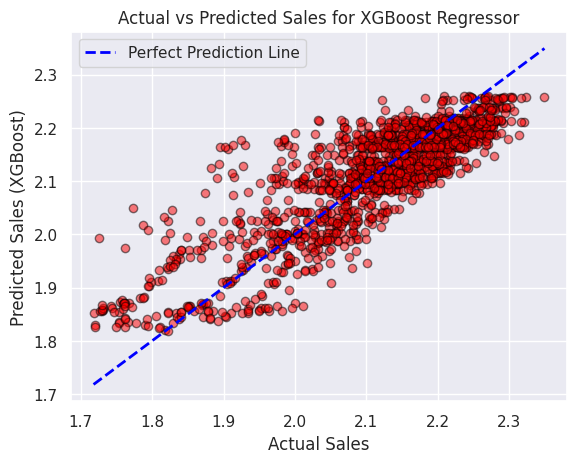

In [ ]:


# Create a DataFrame to compare actual and predicted results for XGBoost
comparison_df_XG = pd.DataFrame({
    'Actual_Sales': Y_test,
    'Predicted_Sales_XG': test_predictions_XG
})

# Scatter plot for visualization Actual vs Predicted Sales for XGBoost
plt.scatter(comparison_df_XG['Actual_Sales'], comparison_df_XG['Predicted_Sales_XG'], alpha=0.5, c='red', edgecolors='black')
plt.plot([min(comparison_df_XG['Actual_Sales']), max(comparison_df_XG['Actual_Sales'])], [min(comparison_df_XG['Actual_Sales']), max(comparison_df_XG['Actual_Sales'])], linestyle='--', color='blue', linewidth=2, label='Perfect Prediction Line')
plt.title('Actual vs Predicted Sales for XGBoost Regressor')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales (XGBoost)')
plt.legend()
plt.show()



In [ ]:
# cross validation
cross_val_score_result = cross_val_score(regressor, X, Y, cv=5).mean()
print(cross_val_score_result)


0.7062689651037257


Linear Regressor

In [ ]:
linear_regressor = LinearRegression()

In [ ]:
# Create a pipeline with polynomial features and the linear regressor
degree = 2
linear_model = make_pipeline(PolynomialFeatures(degree), linear_regressor)


In [ ]:
# Fit the model on the training data
linear_model.fit(X_train, Y_train)


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [ ]:
# Predictions on training data
train_predictions = linear_model.predict(X_train)

In [ ]:
# Predictions on test data
test_predictions = linear_model.predict(X_test)

Evaluation

In [ ]:
# EMean Absolute Error
mae_train = mean_absolute_error(Y_train, train_predictions)
mae_test = mean_absolute_error(Y_test, test_predictions)
print(f"Mean Absolute Error (Train): {mae_train}")
print(f"Mean Absolute Error (Test): {mae_test}")

Mean Absolute Error (Train): 0.04876711143328115
Mean Absolute Error (Test): 0.048726778199697125


In [ ]:
# Mean Squared Error

mse_train = mean_squared_error(Y_train, train_predictions)
mse_test = mean_squared_error(Y_test, test_predictions)

print(f"Mean Squared Error (Train): {mse_train}")
print(f"Mean Squared Error (Test): {mse_test}")

Mean Squared Error (Train): 0.00415988528644379
Mean Squared Error (Test): 0.004071163058345077


In [ ]:
# Root Mean Squared Error
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

print(f"Root Mean Squared Error (Train): {rmse_train}")
print(f"Root Mean Squared Error (Test): {rmse_test}")

Root Mean Squared Error (Train): 0.06449717270116412
Root Mean Squared Error (Test): 0.06380566634982411


In [ ]:
# R-squared Error

r2_train = r2_score(Y_train, train_predictions)
r2_test = r2_score(Y_test, test_predictions)

print(f"R-squared (Train): {r2_train}")
print(f"R-squared (Test): {r2_test}")


R-squared (Train): 0.7046400059536632
R-squared (Test): 0.7286587254117773


In [ ]:
# Create a DataFrame to compare actual and predicted results
comparison_df2 = pd.DataFrame({
    'Actual_Sales': Y_test,
    'Predicted_Sales': test_predictions
})

print (comparison_df)

      Actual_Sales  Predicted_Sales
3797      6.182851         7.645493
5235      7.882146         6.929764
7534      6.438584         7.052734
5425      8.581118         8.486130
8108      7.457078         7.008316
...            ...              ...
5402      7.237915         6.961884
3920      6.374861         6.691391
4254      6.510446         5.946060
8179      6.808843         7.047455
7095      8.627613         8.097061

[1675 rows x 2 columns]


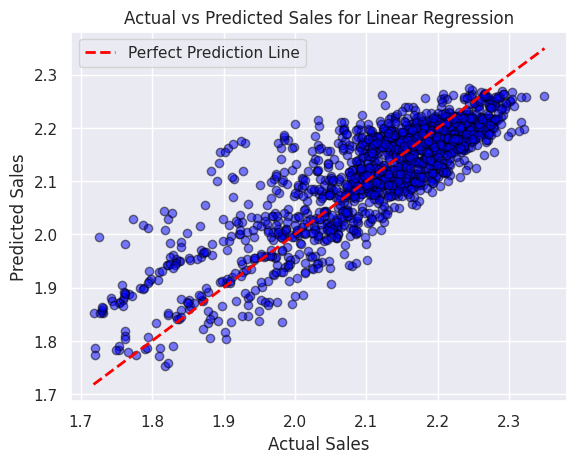

In [ ]:
# Create a DataFrame to compare actual and predicted results
comparison_df2 = pd.DataFrame({
    'Actual_Sales': Y_test,
    'Predicted_Sales': test_predictions
})

# Scatter plot for visualization Actual vs Predicted Sales
plt.scatter(comparison_df2['Actual_Sales'], comparison_df2['Predicted_Sales'], alpha=0.5, c='blue', edgecolors='black')
plt.plot([min(comparison_df2['Actual_Sales']), max(comparison_df2['Actual_Sales'])], [min(comparison_df2['Actual_Sales']), max(comparison_df2['Actual_Sales'])], linestyle='--', color='red', linewidth=2, label='Perfect Prediction Line')
plt.title('Actual vs Predicted Sales for Linear Regression')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.legend()
plt.show()



In [ ]:

# Cross validation for trained model
cross_val_score_result = cross_val_score(linear_model, X, Y, cv=5).mean()
print(cross_val_score_result)


0.7053528945635573
